In [1]:
import numpy as np
import pandas as pd 
import astropy as ap
import matplotlib.pyplot as plt
from astropy.io import ascii

In [2]:
from scipy.stats import binned_statistic_dd
from scipy.stats import linregress
#from astroquery.mast import Catalogs
import mr_forecast as mr
pd.options.display.max_columns = 100
'''
note on mr_forecast: I replaced the Kipping & Chen function with the strictly analytical relationship implemented in Louie
et. al. 2018, which runs more quickly and for our purposes is sufficient. 

EXCEPT for planets with R > Rj 
''';

The goal of this notebook is to re-implement the matlab code written by Natalie in Python. The purpose is to select Tess planets for radial velocity follow-up with the Keck telescope in order to constrain their masses in preparation for further characterization with JWST. 

In [87]:
#Just getting the data - can use TESS or Barclay catalog 
#barclay catalog: https://arxiv.org/pdf/1804.05050.pdf
data_source = 'tess' #make this tess or barclay or exoplanet_archive
if data_source == 'tess':
    tess = pd.read_csv('toi_plus_list-2019-12-9.csv',delimiter=',',header=4)
    c = tess
if data_source == 'barclay':
    bc = ascii.read('barclay_2018_tess_catalog.txt')
    c = bc.to_pandas() #to generalize the use

In [88]:
#getting the TIC info for queries to exofop for star info purposes
#tess['TIC'][0:900].to_csv('ticid_names_only_dec19_001_900.csv',header='False',index=False)
#tess['TIC'][901:].to_csv('ticid_names_only_dec19_901_end.csv',header='False',index=False)

In [89]:
#catalog_2 = star_df.dropna().merge(catalog,left_on='TICID',right_on='TIC ID').reset_index(drop=True)
#commented line above is when you need to do the MAST query
#star_info = pd.read_csv('TIC_wider_crossmatch.csv',delimiter=',',header=4)

#trying it now with a query to https://exofop.ipac.caltech.edu/tess/search.php for
#my TICID list, which returned fewer parameters but might be what I need 
if data_source == 'tess':
    star_info = pd.read_csv('TIC_star_info_dec_9_all.csv',delimiter=',',header=10)
    c['Stellar Mass'] = ((10**c['Surface Gravity Value']) * ((c['Star Radius Value']*6.9551e10)**2) 
                         / 6.67e-8 ) / 1.99e33 
    catalog_2 = pd.merge(c,star_info, left_on = 'TIC', right_on = 'Target')
    c2 = catalog_2.drop(columns=['TFOP SG1a','TFOP SG1b','TFOP SG2',\
                                'TFOP SG3','TFOP SG4','TFOP SG5','TFOP Master',\
                                'TOI Disposition'])
    c = c2.sort_values('Full TOI ID')

In [90]:
#naming all the variables, so it's easier to switch from bc to tess
#future note to self: better to just do all the below as functions, rather than hard-coding all the variables
#at the top; make this change when you've got some spare time

#note: might be easier to have a dictionary of keys, which I could then make calls to 
#by having functions accept the dictionary as input, rather than each key individually...
#not that it makes that much of a difference but it might clean things up a bit

if data_source == 'barclay':
    #rp = catalog['Planet-radius']
    #ms = catalog['Star-mass']
    #pp = catalog['Planet-period']
    #Ts = catalog['Star-teff']
    #ars = catalog['Ars'] #this is the semimajor axis of the orbit over the stellar radius
    #Jmag = catalog['Jmag']
    #Vmag = catalog['Vmag']
    #rs = catalog['Star-radius']
    #dec = catalog['DEdeg'] #declination
    #Fp = catalog['Insol']

    rp_key = 'Planet-radius'
    ms_key = 'Star-mass'
    pp_key = 'Planet-period'
    Ts_key = 'Star-teff'
    ars_key = 'Ars'
    Jmag_key = 'Jmag'
    Vmag_key = 'Vmag'
    rs_key = 'Star-radius'
    dec_key = 'DEdeg'
    Fp_key = 'Insol'
    
if data_source == 'tess':
    #rp = catalog['Planet Radius (R_Earth)']
    #ms = catalog['st_mass']  
    #pp = catalog['Period (days)']
    #Ts = catalog['Stellar Teff (K)']
    #ars = catalog['Ars'] #this is the semimajor axis of the orbit over the stellar radius
    #Jmag = catalog['Jmag']
    #Vmag = catalog['Vmag']
    #rs = catalog['Stellar Radius (R_Sun)']
    #dec = catalog['Dec (degrees)'] #declination
    #Fp = catalog['Planet Insolation (Earth flux)']
    
    rp_key = 'Planet Radius Value'
    ms_key = 'Stellar Mass' 
    pp_key = 'Orbital Period Value'
    Ts_key = 'Effective Temperature Value'
    ars_key = 'Ars'
    Jmag_key = 'J mag' #spaces in mags comes from the exofop catalog; remove space if getting info from MAST
    Vmag_key = 'V mag'
    rs_key = 'Star Radius Value' 
    dec_key = 'TIC Declination'
    Fp_key = 'Effective Stellar Flux Value'
    mp_key = 'pl_masses'
    mp_units = 'Earth'
    id_key = 'Full TOI ID'
    
    #below are the keys for exofop; above are from https://tev.mit.edu:8010/data/collection/193/ 
        #which I think is standard from here on out
    #rp_key = 'Planet Radius (R_Earth)'
    #ms_key = 'Stellar Mass' #the from MAST and a god awful name is 'mass'; change this! 
    #                                #it's "Stellar Mass (M_Sun)" from exofop which is much better
    #pp_key = 'Period (days)'
    #Ts_key = 'Stellar Eff Temp (K)'
    #ars_key = 'Ars'
    #Jmag_key = 'J mag' #spaces in mags comes from the exofop catalog; remove space if getting info from MAST
    #Vmag_key = 'V mag'
    #rs_key = 'Stellar Radius (R_Sun)' 
    #dec_key = 'Dec_y'
    #Fp_key = 'Planet Insolation (Earth Flux)'
    #mp_key = 'pl_masses'
    #mp_units = 'Earth'
    
if data_source == 'exoplanet_archive':
    
    rp_key = 'pl_radj' #FINISH FILLING THIS IN BELOW HERE 
    ms_key = 'st_mass'
    pp_key = 'pl_orbper'
    Ts_key = 'st_teff'
    ars_key = 'Ars'
    Jmag_key = 'st_j'
    Vmag_key = 'st_vj'
    rs_key = 'st_rad'
    dec_key = 'dec'
    Fp_key = 'pl_insol'

In [91]:
#manually creating something for known planets
exoarch_keys = ['pl_rade','st_mass','pl_orbper','st_teff','Ars','st_j',
                'st_vj','st_rad','dec','pl_insol', 'pl_masse']
all_planets = pd.read_csv('transits_above_v16.csv',header=101)
ap = all_planets
known_planets = pd.DataFrame({
    rp_key : ap[exoarch_keys[0]],
    ms_key : ap[exoarch_keys[1]],
    pp_key : ap[exoarch_keys[2]],
    rs_key : ap[exoarch_keys[7]],
    Ts_key : ap[exoarch_keys[3]],
    Jmag_key : ap[exoarch_keys[5]],
    Vmag_key : ap[exoarch_keys[6]], 
    dec_key : ap[exoarch_keys[8]],
    Fp_key : ap[exoarch_keys[9]]
})

In [92]:
def basic_mr(r):
    m = np.zeros(len(r))
    for i in np.arange(len(r)):
        m[i] = (0.9718 * ((r[i])**3.58)) if r[i] < 1.23 \
        else (1.436 * ((r[i])**1.7)) if r[i] < 14.26 \
        else 317.8
    return m

In [93]:
#### doing the same thing for KOI / K2 candidates
#note: I cut anything with R > 25 Re 
k2_candidates = pd.read_csv('k2_above_v14.csv',header=35)
k2c = k2_candidates
koi_candidates = pd.read_csv('KOI_above_v14.csv',header=67)
koic = koi_candidates

koi_keys = ['koi_prad','koi_smass','koi_period','koi_steff','Ars','koi_jmag',
                'koi_gmag','koi_srad','dec','koi_insol', 'pl_masse']
k2_keys = ['pl_rade','stlogg','pl_orbper','st_rad','st_teff','st_j2','st_vj','dec']

kois = pd.DataFrame({
    id_key : koic['kepoi_name'],
    rp_key : koic[koi_keys[0]],
    ms_key : koic[koi_keys[1]],
    pp_key : koic[koi_keys[2]],
    rs_key : koic[koi_keys[7]],
    Ts_key : koic[koi_keys[3]],
    Jmag_key : koic[koi_keys[5]],
    Vmag_key : koic[koi_keys[6]], 
    dec_key : koic[koi_keys[8]],
    Fp_key : koic[koi_keys[9]],
    mp_key: basic_mr(koic[koi_keys[0]])
})


k2 = pd.DataFrame({
    id_key : k2c['epic_candname'],
    rp_key : k2c[k2_keys[0]],
    ms_key : ((10**k2c['st_logg']) * ((k2c['st_rad']*6.9551e10)**2) 
                          / 6.67e-8 ) / 1.99e33 , #since they only give logg and not Ms 
                                                 #for some reason
    pp_key    : k2c[k2_keys[2]],
    rs_key    : k2c[k2_keys[3]],
    Ts_key    : k2c[k2_keys[4]],
    Jmag_key  : k2c[k2_keys[5]],
    Vmag_key  : k2c[k2_keys[6]],
    dec_key   : k2c[k2_keys[7]],
    mp_key: basic_mr(k2c[k2_keys[0]]) 
    
})

In [94]:
def mass_getter(planet_data, rad_key, mass_key):
    planet_mass = np.zeros(len(planet_data[rad_key]))
    big_ones = planet_data[rad_key]>14.26 #i.e. too big for the empirical relation
    masked_ones = pd.isna(planet_data[mass_key])
    
    i = 0
    while i < len(planet_mass):
        if masked_ones[i] and not big_ones[i]:
            #if the entry is masked (i.e. zero) AND it's small, use the empirical relationship
            planet_mass[i] = (0.9718 * ((planet_data[rad_key][i])**3.58)) if planet_data[rad_key][i] < 1.23 \
            else (1.436 * ((planet_data[rad_key][i])**1.7)) #Earth Masses
        i+=1
        
    #planet_mass[np.logical_and(big_ones, masked_ones)] = \
    #    mr.Rpost2M(planet_data[rad_key][np.logical_and(big_ones, masked_ones)],unit='Earth')
    #for the entries which are masked and big, apply the statistical relationship
    
    planet_mass[np.logical_and(big_ones, masked_ones)] = 317.8 #anything really big is just Jupiter fck it lol
                                                                #it's outside our bin regime anyway
    
    planet_mass[~masked_ones] = planet_data[mass_key][~masked_ones]
    #for unmasked entries, take the existing values
    
    return np.round(planet_mass,4)

known_planets[mp_key] = mass_getter(ap,exoarch_keys[0],exoarch_keys[10])

In [95]:
def ars_from_t(period,star_mass,star_radius):
    '''
    period should be given in days; star mass and radius in
    terms of their value in solar units. These units seem
    to be pretty much standard across exoplanet databases
    so I have not implemented any sort of unit options
    in this function.
    '''
    G = 6.6726e-11
    Msun = 1.989e30
    Mstar = star_mass * Msun
    period_s = period * 86400
    a_m = (G*Mstar*(period_s**2) / (4 * (np.pi**2))) ** (1/3)
    star_radius_m = star_radius * 6.9551e8 #sun radius in m
    ars = a_m / star_radius_m
    #this value is correct for earth 
    return ars

known_planets[ars_key] = ars_from_t(known_planets[pp_key],known_planets[ms_key],known_planets[rs_key])
k2[ars_key] = ars_from_t(k2[pp_key],k2[ms_key],k2[rs_key])
kois[ars_key] = ars_from_t(kois[pp_key],kois[ms_key],kois[rs_key])

In [96]:
if data_source == 'tess':
    c = c[np.logical_and.reduce((c[rp_key]>0, c[pp_key]>0, c['Source Pipeline']=='spoc'))]
    c[ars_key] = ars_from_t(c[pp_key], c[ms_key], c[rs_key]) #because there is no ars data in the tess datafile
    c = c.reset_index(drop=True)

In [97]:
#Calculating Optimistic mass based on relation in Chen & Kipping 2016 (https://arxiv.org/pdf/1603.08614.pdf) and direct 
#empircal implementation by Louie et. al. 2018 (https://iopscience.iop.org/article/10.1088/1538-3873/aaa87b)
def m_from_r(radii):
    masses = np.zeros(len(radii))
    i = 0
    while i < len(radii):
        masses[i] = (0.9718 * (radii[i]**3.58)) if radii[i] < 1.23\
        else (1.436 * (radii[i]**1.7)) if radii[i] < 14.26\
        else -1
        #don't use this analysis for planets outside the neptune regime: return -1
        i += 1
    return masses

c[mp_key] = m_from_r(c[rp_key])

In [98]:
def k_amp_finder(star_mass,star_radius,planet_mass,ars,mp_units):
    '''
    finds the amplitude of stellar oscillations due to the planet's orbit 
    star_mass: units of m_sun
    star_radius: units of r_sun
    planet_mass: units of m_earth or m_jup (should be able to set "mp_units = mp_units" as that 
                                            variable is named higher up in the chain. Note "Earth"
                                            is capitalized, if you set this manually. 
    ars: ratio of semimajor axis and stellar radius. This is used as an input instead of a alone 
                        because a is often not directly available from these datasets. 
    '''
    
    G = 6.67e-11 #SI units
    Msun = 1.98e30 #kg
    Rsun = 6.9551e8 #meters
    v_star = np.sqrt(G*star_mass*Msun/(ars*star_radius*Rsun)) 
    #this is actually backwards
    
    mp_factor = 5.972e24 if mp_units == 'Earth' else 1.898e27
    v_pl = v_star * ((planet_mass*mp_factor)/(star_mass*Msun))
    
    return v_pl
    
c['K_amp'] = k_amp_finder(c[ms_key],c[rs_key],c[mp_key],c[ars_key],mp_units)
known_planets['K_amp'] = k_amp_finder(known_planets[ms_key],known_planets[rs_key],\
                                      known_planets[mp_key],known_planets[ars_key],mp_units)
k2['K_amp'] = k_amp_finder(k2[ms_key],k2[rs_key],k2[mp_key],k2[ars_key],mp_units)
kois['K_amp'] = k_amp_finder(kois[ms_key],kois[rs_key],kois[mp_key],kois[ars_key],mp_units)

In [99]:
#Calculating Webb SNR Proxy
#taken from Kempton et. al. : https://arxiv.org/pdf/1805.03671.pdf
#note: implement "ars" and "mp" being "None" so there's an option for the
#function to calculate them internally, making it more generally applicable

def get_TSM(planet_radius,star_radius,star_teff,Jmag,planet_mass,ars):
    
    scale_factors = np.zeros(len(planet_radius))
    i = 0
    while i < len(planet_radius):
        #from Table 1 in Kempton et. al. 
        scale_factors[i] = 0.19 if planet_radius[i]<1.5\
        else 1.26 if np.logical_and(planet_radius[i]>1.5,planet_radius[i]<2.75)\
        else 1.28 if np.logical_and(planet_radius[i]>2.75, planet_radius[i]<4)\
        else 1.15
        i += 1
    
    Teq = star_teff * (np.sqrt(1/ars)*(0.25**0.25)) #eqn 3 in Kempton et. al <- this is how I calculated TSM
   
    #TSM is transmission spectroscopy metric
    TSM = scale_factors * (planet_radius**3) * Teq * (10**(-Jmag/5)) / (planet_mass * (star_radius**2))
    return TSM

c['TSM'] = get_TSM(c[rp_key],c[rs_key],c[Ts_key],c[Jmag_key],c[mp_key],c[ars_key])
known_planets['TSM'] = get_TSM(known_planets[rp_key],known_planets[rs_key],
                                        known_planets[Ts_key],known_planets[Jmag_key],
                                        known_planets[mp_key],known_planets[ars_key])
kois['TSM'] = get_TSM(kois[rp_key],kois[rs_key],kois[Ts_key],kois[Jmag_key],
                                        kois[mp_key],kois[ars_key])
k2['TSM'] = get_TSM(k2[rp_key],k2[rs_key],k2[Ts_key],k2[Jmag_key],
                                        k2[mp_key],k2[ars_key])

In [100]:
def get_Fp(ars,ts,rs):
    rsun=696265; #km
    au=149598000; #km
    Ls = ((rs)**2) * ((ts/5777)**4)
    a = ars * rs * rsun / au #this is a/rs * rs (giving a in units of rsun) * rsun (giving the km value)
    Fp = Ls / (a**2)
    #teq = ts * (np.sqrt(1/ars) * (0.25**0.25)
    #Fp = 4 * ((np.sqrt(ars/(au/rsun)) * (teq/278.68))**4)
    return Fp

known_planets[Fp_key] = get_Fp(known_planets[ars_key],known_planets[Ts_key],known_planets[rs_key])
k2[Fp_key] = get_Fp(k2[ars_key],k2[Ts_key],k2[rs_key])

In [101]:
#desirables = np.logical_and.reduce((Jmag<12, Vmag<14, dec<20, catalog['K_amp']>2))
desirables = np.logical_and(c[dec_key]>-20, c['K_amp']>2)

#observability limits for Keck

In [102]:
catalog_cleaned = c[desirables]#.drop_duplicates(subset='TOI') #removed for barclay catalog
cc = catalog_cleaned.reset_index(drop=True)

In [103]:
#cc = pd.read_csv('tess_data_with_ticid_info.csv')
#need to cut TESS planets on dec and vmag (since for TKS we only care about the ones 
# that we can observe) 
kp = known_planets
kp[id_key] = ap['pl_name']
p1 = kp.append(kois,sort=False)
p2 = p1.append(k2,sort=False)
cc2_temp = cc.append(p2, sort=False)
cc_nocuts = cc2_temp #for planets we don't care about actually being able to observe
                    #although note that I've already made the Vmag cut 
d2 = cc2_temp['K_amp']>1.5 #this is not just a TKS observability cut: planets
                        #with such low K_amps are probably not going to be 
                        #good atmospheric candidates for ANYONE, TKS or not, 
                        #because their masses are going to be pretty speculative
                        #this also has the ancillary benefit of cutting the 
                        #ultra long-period KOIs, which are interesting but
                        #probably not atmospheric targets
cc2_t2 = cc2_temp[d2]
cc2 = cc2_t2.reset_index(drop=True)

In [104]:
#defining new bins - as per Natalie
rad_bins = 10**(np.linspace(0,1,6))
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
all_bins = [rad_bins, fpl_bins, tef_bins]

def binning_function(dataset,bins,id_key,sort_val):
    
    rad_bins = bins[0]
    fpl_bins = bins[1]
    tef_bins = bins[2]

    pre_bin = dataset.assign(
        radius_bin = pd.cut(dataset[rp_key],bins=rad_bins,labels = [1,2,3,4,5]),
        insol_bin = pd.cut(dataset[Fp_key],bins=fpl_bins,labels = [1,2,3,4,5]),
        st_Teff_bin = pd.cut(dataset[Ts_key],bins=tef_bins,labels = [1,2,3])
    )
        #pd.cut returns the bin number (or label - ints chosen here for ease)
        #of each row based on its place within a specified column. 
    
    binned = pre_bin.dropna(subset=['radius_bin','insol_bin','st_Teff_bin']).groupby(['radius_bin',\
                                    'insol_bin','st_Teff_bin']).apply(lambda _pre_bin:\
                                    _pre_bin.sort_values(by=[sort_val],ascending=False)).reset_index(level = 3,drop=True)
                    #this multi-line call: 
                        #1) drops values which are not in any of the desired bins 
                        #2) groups within those bins
                        #3) sorts by TSM (the lambda thing is necessary because "groupby" produces a "groupby object"
                                #which can't be operated on normally)
                        #4) drops all indexes which are not the bin numbers, which were just 1 to N anyway and therefore
                                #were worthless 
    
    all_idx = binned.index.to_list()
    unique_idx = []
    for element in all_idx: 
        if element not in unique_idx:
            unique_idx.append(element)
    
    binned['priority'] = np.zeros(len(binned))
    for idx in unique_idx:
        
        bin_items = len(binned.loc[idx].sort_values(sort_val,ascending=False).iloc[0:3].sort_values(Vmag_key)[id_key])
            #the number of objects in each bin

        if bin_items >= 3:
            binned.loc[binned[id_key] == binned.loc[idx].sort_values(sort_val,ascending=False).iloc[0:3]\
                       .sort_values(Vmag_key)[id_key].iloc[0],'priority'] = 1
            binned.loc[binned[id_key] == binned.loc[idx].sort_values(sort_val,ascending=False).iloc[0:3]\
                       .sort_values(Vmag_key)[id_key].iloc[1],'priority'] = 2
            binned.loc[binned[id_key] == binned.loc[idx].sort_values(sort_val,ascending=False).iloc[0:3]\
                       .sort_values(Vmag_key)[id_key].iloc[2],'priority'] = 3
            continue
            
        elif bin_items == 2:
            binned.loc[binned[id_key] == binned.loc[idx].sort_values(sort_val,ascending=False).iloc[0:3]\
                       .sort_values(Vmag_key)[id_key].iloc[0],'priority'] = 1
            binned.loc[binned[id_key] == binned.loc[idx].sort_values(sort_val,ascending=False).iloc[0:3]\
                       .sort_values(Vmag_key)[id_key].iloc[1],'priority'] = 2
            continue
            
        elif bin_items == 1:
            binned.loc[binned[id_key] == binned.loc[idx].sort_values(sort_val,ascending=False).iloc[0:3]\
                       .sort_values(Vmag_key)[id_key].iloc[0],'priority'] = 1
    
        #this is a HIDEOUS call but the idea is: 
            #you are going into each bin sequentially (by index), sorting by TSM, then sorting those top 3 by Vmag. 
            #then, you are taking out the TOI value of the top entry there (i.e., highest priority)
            #THEN, you are indexing that TOI in the list, .loc'ing to that row and the priority column, and setting 
            #THAT entry to 1. Then repeating this for the other priority values 
            
            #all these if statements are a lot but unless I want to predefine 
            #how many are in each bin (?) I think this is the fastest way to go, and as long as 
            #TESS keeps its number of targets < 10^5 or something this shouldn't be unacceptably
            #long in terms of its run time 
    return binned

In [105]:
binned = binning_function(cc,all_bins,'Full TOI ID','TSM')
binned2 = binning_function(cc2,all_bins,'Full TOI ID','TSM')
#nocuts_bins = binning_function(cc_nocuts,all_bins,'Full TOI ID','TSM')
#binned 2 is the one with the exoplanet archive included

In [106]:
#rewriting this to include ExoArch planets
my_tois_or = binned[binned['priority']==1].reset_index(drop=True)[id_key].values
np.sort(my_tois_or)

array([ 233.01,  390.01,  421.01,  455.01,  460.01,  507.01,  509.01,
        526.01,  538.01,  560.01,  620.01,  635.01,  638.01,  680.01,
        732.02, 1135.01, 1136.02, 1144.01, 1238.02, 1264.01, 1268.01,
       1278.01, 1284.01, 1285.01, 1410.01, 1415.01, 1416.01, 1424.01,
       1430.01, 1436.01, 1459.01, 1467.01, 1468.02, 1471.01, 1473.01])

In [107]:
my_tois = binned2[binned2['priority']==1].reset_index(drop=True)[id_key].values
my_tois

array([455.01, 'GJ 357 b', 'HD 219134 c', 1238.02, 'GJ 9827 b',
       'K2-138 b', 'K2-141 b', 635.01, 'K2-288 B b', 'TOI 270 c',
       'K2-17 b', 'K2-263 b', 1467.01, 'HD 97658 b', 'K2-222 b', 1285.01,
       'HD 219134 b', 'pi Men c', '55 Cnc e', 'HD 3167 b', 233.01,
       'GJ 143 b', 'Kepler-20 d', 'GJ 1214 b', 560.01, 509.01, 1284.01,
       1410.01, 'EPIC 212178066.01', 'K2-100 b', 526.01,
       'EPIC 220292715.01', 'K08217.01', 'GJ 3470 b', 1424.01, 1471.01,
       1144.01, 'DS Tuc A b', 'K2-39 b', 680.01, 'K01208.01', 1278.01,
       'K05603.01', 'EPIC 220192485.01', 507.01, 1268.01, 421.01, 460.01,
       1264.01, 1135.01, 390.01], dtype=object)

In [24]:
non0_tois = binned2[binned2['priority']!=0]
for_joey = np.zeros(np.shape(non0_tois[[id_key,'priority']]))

for i in np.arange(len(non0_tois[[id_key,'priority']])):
    if type(non0_tois[id_key][i]) == float:
        for_joey[i,:] = np.array([non0_tois[id_key][i],non0_tois['priority'][i]])
    
fj = pd.DataFrame({
    'TOI' : for_joey[:,0],
    'Priority' : for_joey[:,1]
    })

fj[fj['TOI'] != 0].sort_values('TOI').to_csv('priority_list.csv',index=False)

In [25]:
for toi in my_tois:
    if (toi not in my_tois_or):
        print(toi)

GJ 9827 b
K2-141 b
K2-263 b
HD 97658 b
K2-198 d
HD 219134 b
55 Cnc e
HD 3167 b
K2-266 e
K05654.01
K2-100 b
EPIC 220292715.01
K08217.01
GJ 3470 b
K2-39 b
K01208.01
K05603.01
EPIC 220192485.01
1423.01


C:\Users\nscarsdale\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [26]:
def planck_microns(T,wavelength):
    '''
    note input is in microns! 
    '''
    c = 3e8 #m/s
    h = 6.626e-34
    kb = 1.38e-23
    wav_meters = wavelength / 1e6
    B = 2 * h * c / ((wav_meters**5) * (np.exp(h*c/(wav_meters * kb * T))-1))
    return B

def get_ESM(planet_teq, star_teff, planet_radius, star_radius, Kmag, rp_units = 'jupiter',rs_units='solar'):
    
    dayside_teq = 1.1 * planet_teq
    planet_b = planck_microns(dayside_teq,4)
    star_b = planck_microns(star_teff,4) #note: may want to use 7.5 instead of 4 since the prefactor in Kempton
                                            #is scaled based on the LRS bandpass for a specific planet
                                            #Although I should still get consistent *relative* ESM values. 
    
    if rp_units == 'earth':
        rp_m = 6.371e6 * planet_radius
    elif rp_units == 'jupiter':
        rp_m = 6.9911e7 * planet_radius
    if rs_units == 'solar':
        rs_m = 6.9551e8 * star_radius
    
    ESM = 4.29e6 * (planet_b / star_b) * ((rp_m/rs_m)**2) * (10**(-Kmag/5))
    
    return ESM

NOTE

TKS is using Teff < 6500, NAtalie 10^5, and Rstar < 5.5 
after this, want a file with prioritization 
want to prioritize all P = 1, 2, 3 targets 
       read in confirmed planets from exoplanet archive and compare quality 
       give priority to empty cells 
       give priority to p = 1 (of course) 
       naively, just sort by p; however, how to sort within priority 1? 
       i.e., is there anything better in a "cell" (bin) - how many? 
write out CSV file that could be read into excel. Include a bunch of stuff (P + S properties) 
    for P: R, P, Fp, Mp (if available - create binary value for "was it calculated or measured") 
        name: put name and alternate name (e.g. TOI xxx.xx, WASP-xx) 
        toggles: 0, 1 for "is Kepler, is K2, is TESS") 
    for S: logg, Rs, Vmag, Jmag, Teff, Rs
    also, TSM, ESM, priority, Kamp, numeric value for cell # 
    would be nice if we could look at the # and know immediately where it resides 
    do a three digit integer: want it as Rp, Fp, Teff (low to high) 
    there will be additional historical info and a comments field. Append new comments using | or ; 
        e.g.: "on TKS target list", "previously observed", "vetting status": on confluence, there was a list of criteria that 
           Theo was using related to this 
                could do something fancy, e.g. include links to vetting reports (TESS TOI working group does this when they 
                create spreadsheets; there are cells with links to vetting reports) 
        also want observability: e.g. Mar Apr May it has airmass above 2. (would put "MarAprMay" as "345") - I should think aby 
        this
    something like Theo's visibility plots (airmass as function of UT) - might put this as "mean hours per night as a function 
    of month"
    last thing: what if there are 5 confirmed planets in a cell, and they're all better than the TESS target? Or a new TESS 
    release demotes a formerly P = 1 target? I think a "highest lifetime priority" column might work. Could also do a string 
    which is a concatenation of all previous priorities (e.g. "1111111222222233000000" for something that's steadily getting 
    kicked off)
    Natalie wants to know if a target has been observed with RV measurements. Like, what's the quality of the RV signal (not 
    worry about that yet) 
For Webb: how many planets do we need in a bin? Maybe at least 4 (one for every epoch), maybe 3 (2/3 will be hazy?) maybe 12 (for both of those things)
Also: if we've already observed something for, like, 2 months, why on earth would we get rid of it?? 


In [87]:
s_1_13 = np.zeros(len(binned2['Sectors']))
vecint = np.vectorize(int)
i = 0
for sectors in binned2['Sectors']:
    if type(sectors) == str:
        if len(sectors) == 1:
            secint = int(sectors)
            if secint <= 13:
                s_1_13[i] = 1
        else:
            secint = vecint(sectors.split())
            #print(secint)
            for sector in secint:
                print(np.max(sector))
                if np.max(sector) <= 13:
                    s_1_13[i] = 1
            

14
15
16
14
15
15
14
15
14
15
16
10
14
15
15
14
14
15
16
14
15
16
14
15
14
15
16
15
15
16
16
14
14
15
16
14
15
14
15
14
15
16
15
16
14
15
16
15
16
14
14
15
16
14
15
16
14
14
15
16
14
14
15
16
15
16
16
14
15
16
16
15
14
15
14
15
15
16
16
14
15
16
14
15
16
14
16
15
14
15
16
14
15
16
14
15
14
15
16
14
15
14
16
14
15
14
15
14
15
14
15
14
15
16
14
15
14
15
15
16
15
16
16
14
14
15
16
14
15
15
16
14
15
14
15
5
6
16
14
15
16
16
14
14
14
15
16
14
15
16
14
15
14
15
16
14
15


In [84]:
s_1_13

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
vecint = np.vectorize(int)
vecstr = np.vectorize(str)
binned2['highestp'] = vecstr(vecint(binned2['priority']))
binned2.to_csv('test.csv')

In [28]:
test['highestp'] = np.core.defchararray.add(vecstr(test['highestp']), vecstr(vecint(test['priority'])))
test

NameError: name 'test' is not defined

In [209]:
#don't make V cuts until after we rank them - then we can be aware of good targets that are dim / M dwarves
#could we make a graphic where each square had a name/TOI number, Vmag, Jmag, priority (for top few / bin)
#6 characters: e.g. gj1214 or k20018 
#flags in NASA ExoArch for IsKepler, IsK2, 
#should also add KOI and K2 candidate lists to this (those will not change so should just be a single thing)
    #those are on NASA ExoArch, they have their own tables
#make 5 pages (one for each Rp bin) with boxes for each bin containing the info above 
#relax Vmag to 16 so we can get M dwarf targets.
#add "does it have a mass already"
#some observability informations: e.g., what quarters it can be seen in

'ab'

More from Natalie: 

make sure that we're actually getting the Sector 14, 15, 16 targets (SPOC)

In [24]:
aois = binned2[binned2['priority']!=0]

In [25]:
def colorfinder(priority):
    if priority == 1:
        return 'green'
    if priority == 2:
        return 'yellow'
    if priority == 3:
        return 'orange'

In [26]:
def bin_plotter(rbin):
    rbin1 = aois.loc[rbin,:,:]
    F = np.array(rbin1[Fp_key])
    Ts = np.array(rbin1[Ts_key])
    rp = np.array(rbin1[rp_key])
    P = np.array(rbin1['priority'])
    #okay, so I think one useful method would be to try to print these and use the
    #annotate function 
    #(https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point)
    #and see how that works (i.e. whether it's legible)
    fig, ax = plt.subplots(figsize=(14,9))
    figsize=[10,7]
    ax.grid()
    txt = np.array(rbin1[id_key])
    
    #doing the title stuff
    bin_edges = np.round(10**(np.linspace(0,1,6)),1)
    title_txt = r'Planets & Planet Candidates With Radius Between ' + str(bin_edges[rbin-1]) + r' and ' + \
        str(bin_edges[rbin]) + r'$R_\oplus$'

    
    for i in np.arange(len(rbin1)):
        ax.semilogx(F[i], Ts[i], '.',ms=rp[i]*5,color=colorfinder(P[i]))
        ax.annotate(txt[i], (F[i], Ts[i]+rp[i]*9))
    ax.set_yticks(tef_bins)
    ax.set_xticks(fpl_bins)
    ax.set_ylabel('Stellar Effective Temperature (K)')
    ax.set_xlabel(r'Insolation Flux')
    ax.set_title(title_txt)

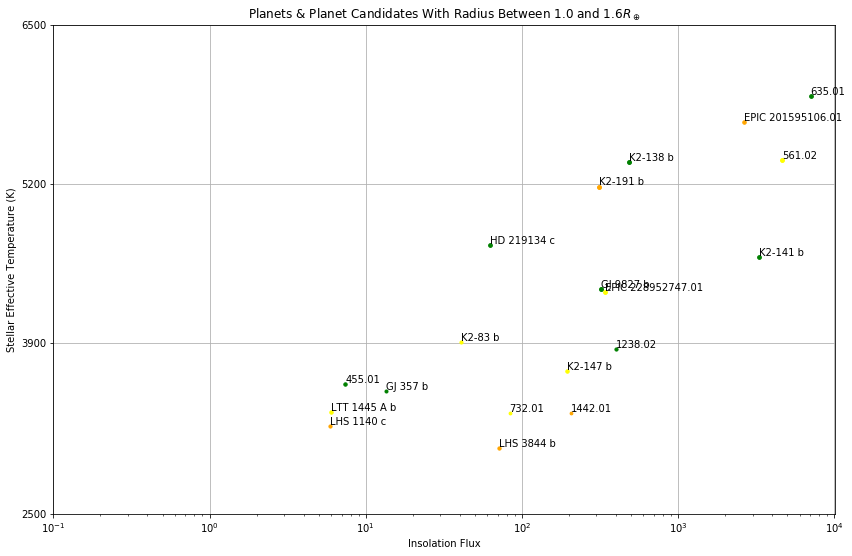

In [27]:
bin_plotter(1)
#implement slider bar to switch between radii bins 

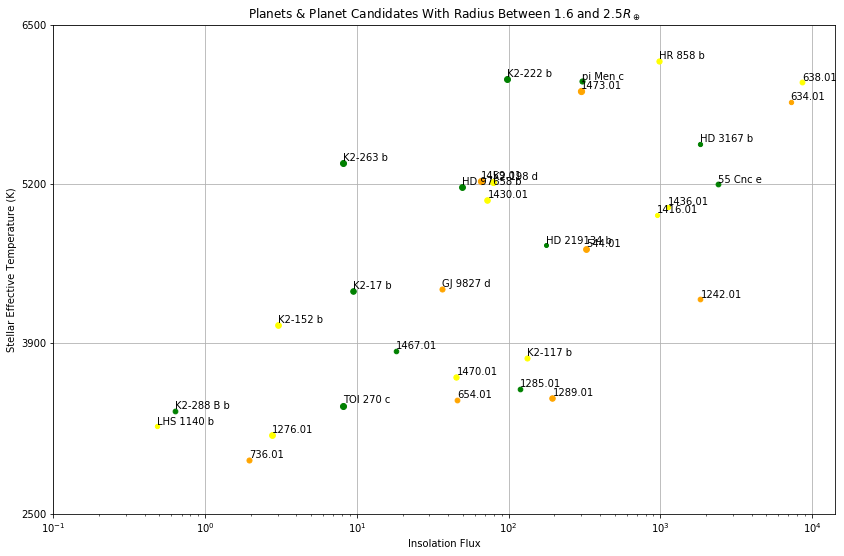

In [28]:
bin_plotter(2)

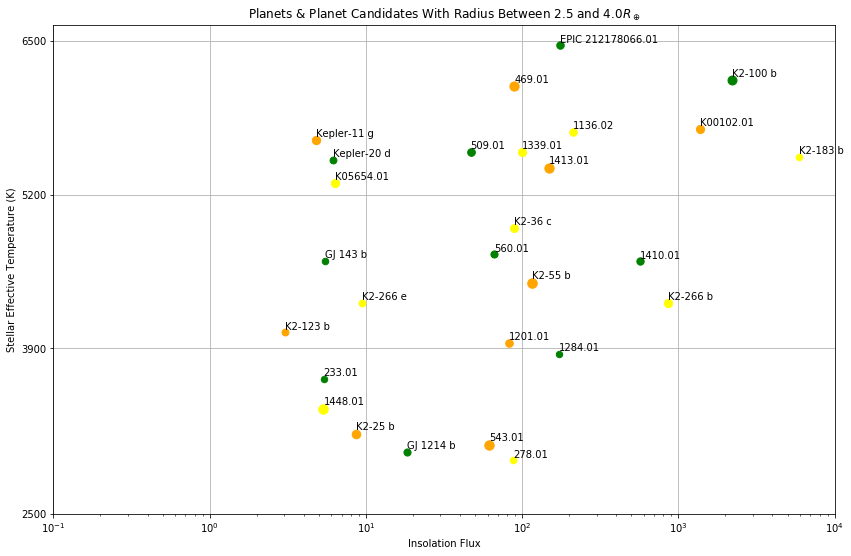

In [29]:
bin_plotter(3)

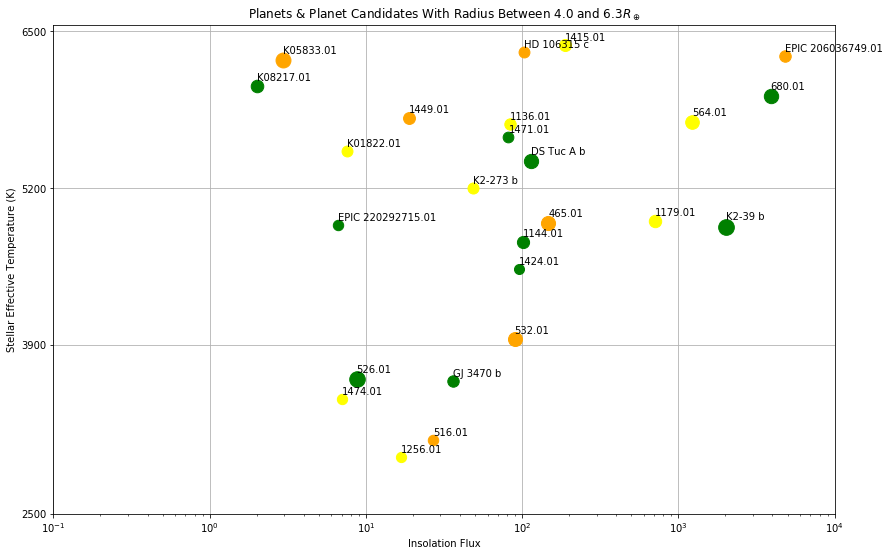

In [30]:
bin_plotter(4)

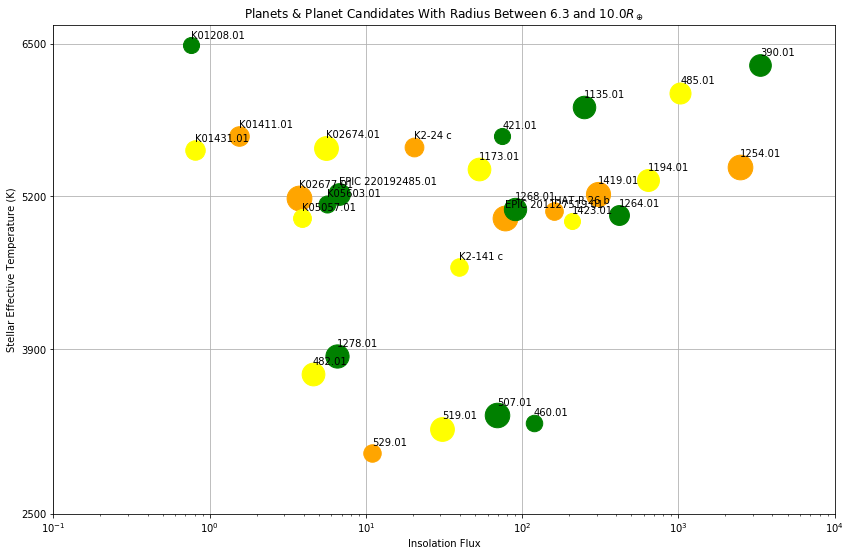

In [31]:
bin_plotter(5)

In [ ]:
#get cumulative results of up to S13 and then start appending current priorities after that 

In [134]:
binned[np.round(binned[id_key],1) == 509]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Edited,Stellar Mass,Target,RA,Dec,V mag,J mag,H mag,K mag,Ars,pl_masses,K_amp,TSM,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,3,spoc,453211454,509.01,117.92497,9.386054,7.905,0.018,1494.445731,0.001498,18.119809,0.002151,3.669772,0.189904,891.412821,42.6545,7,Looks like a transit signal but there is a pos...,4.438,0.0,1,0.996346,0.089708,3.073257,0.499603,667.154613,5560.26,43.3509,46.819522,19.772907,False,2019-03-15 15:42:21+0000,2019-10-17 00:41:46+0000,0.991855,453211454,117.924642,9.385241,8.58,7.304,6.964,6.881,29.067262,9.684396,2.374869,97.542021,3,3,3,1.0


In [112]:
binned2.loc[3,3,3]

Source Pipeline          TIC  \
radius_bin insol_bin st_Teff_bin                                
3          3         3                      spoc  269701147.0   
                     3                      spoc   33692729.0   
                     3                      spoc  453211454.0   
                     3                      spoc  377064495.0   
                     3                      spoc  269701147.0   
                     3                      spoc  269701147.0   
                     3                       NaN          NaN   
                     3                      spoc  232540264.0   
                     3                      spoc  377064495.0   
                     3                      spoc  224297258.0   
                     3                      spoc  153949511.0   
                     3                       NaN          NaN   
                     3                      spoc   49687222.0   
                     3                      spoc  229944666.0   
                     3                      spoc  232976128.0   
                     3                       NaN          NaN   
                     3                      spoc  264979636.0   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
...                                          ...          ...   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
   

In [43]:
for toi in my_tois:
    if type(toi) == float:
        if toi > 1450:
            print(toi)

1467.01
1471.01


In [58]:
kp[np.logical_and(kp['K_amp'] > 1.5, kp['K_amp'] < 2)]

,Planet Radius Value,Stellar Mass,Orbital Period Value,Star Radius Value,Effective Temperature Value,J mag,V mag,TIC Declination,Effective Stellar Flux Value,pl_masses,Ars,K_amp,TSM,Full TOI ID
1,1.511,0.81,6.764580,0.78,4699.00,3.981,5.570,57.168354,62.411963,4.3600,17.993824,1.699548,205.218714,HD 219134 c
2,2.042,1.09,6.267900,1.10,6037.00,4.869,5.670,-80.469124,307.131467,4.8200,13.388338,1.581148,227.954509,pi Men c
4,2.085,1.15,3.585990,1.31,6201.00,5.473,6.400,-30.814520,985.099674,5.0077,7.887327,1.909357,166.874367,HR 858 b
21,1.639,1.41,2.785780,1.90,6305.00,7.229,8.250,38.714016,2707.324958,5.0800,4.918656,1.839300,21.786293,Kepler-21 b
39,2.860,0.94,29.838320,0.87,5528.00,7.548,8.940,4.381469,18.616337,8.5699,45.596913,1.844518,82.656903,HD 3167 c
49,2.838,1.21,17.833648,1.35,6273.00,8.417,9.500,45.139832,124.765019,8.4582,22.680397,1.826381,36.646848,Kepler-410 A b
52,2.390,1.00,15.387063,1.09,6058.00,8.423,9.543,11.753423,97.798099,6.3158,23.891302,1.626648,41.531464,K2-222 b
88,2.022,0.61,6.201470,0.60,4340.00,7.984,10.250,-1.286273,36.454404,4.0400,20.084034,1.958456,124.102175,GJ 9827 d
98,2.070,1.02,6.326763,0.97,5741.00,9.081,10.364,-15.937820,201.628896,4.9466,14.943255,1.690817,38.501821,K2-277 b
124,2.640,0.80,24.366200,0.74,4950.00,8.968,10.726,-20.231684,12.632088,7.4796,44.383271,1.917813,47.832278,K2-233 d


In [ ]:
#eventually, want to dig deep on all of these targets (incl. KOI and K2OI for these targets)
#FOR TOI509.01 : look for public light-curve tools
    #once we have mass, do joint fit on photometry and R
#re: FELLOWSHIPS IF it's useful to have a NASA connection on FINNEST, reach out to Tom Greene at Ames
#Meet with Tom Greene tomorrow 

In [73]:
aois2 = aois[vectype(aois[id_key])==float]

In [78]:
aois2[aois2[id_key] > 1100][[id_key,'priority']].sort_values(id_key)

,,,Full TOI ID,priority
radius_bin,insol_bin,st_Teff_bin,,
5,4,3,1135.01,1.0
4,3,3,1136.01,2.0
3,4,3,1136.02,2.0
4,4,2,1144.01,1.0
5,3,3,1173.01,2.0
4,4,2,1179.01,2.0
5,4,3,1194.01,2.0
3,3,2,1201.01,3.0
1,4,1,1238.02,1.0


In [129]:
d = 2458494.4457
while d < 2458494.4457 + 500:
    print(d)
    d += 18.119809 / 365
    #1.5 is july 18, 2020

2458494.4457
2458494.495343312
2458494.5449866243
2458494.5946299364
2458494.6442732485
2458494.6939165606
2458494.7435598727
2458494.793203185
2458494.842846497
2458494.892489809
2458494.942133121
2458494.9917764333
2458495.0414197454
2458495.0910630575
2458495.1407063697
2458495.190349682
2458495.239992994
2458495.289636306
2458495.339279618
2458495.38892293
2458495.4385662423
2458495.4882095545
2458495.5378528666
2458495.5874961787
2458495.637139491
2458495.686782803
2458495.736426115
2458495.786069427
2458495.8357127393
2458495.8853560514
2458495.9349993635
2458495.9846426756
2458496.0342859877
2458496.0839293
2458496.133572612
2458496.183215924
2458496.232859236
2458496.2825025483
2458496.3321458604
2458496.3817891725
2458496.4314324846
2458496.4810757968
2458496.530719109
2458496.580362421
2458496.630005733
2458496.679649045
2458496.7292923573
2458496.7789356695
2458496.8285789816
2458496.8782222937
2458496.927865606
2458496.977508918
2458497.02715223
2458497.076795542
2458497.12

2458540.961483452
2458541.011126764
2458541.0607700762
2458541.1104133883
2458541.1600567005
2458541.2097000126
2458541.2593433247
2458541.308986637
2458541.358629949
2458541.408273261
2458541.457916573
2458541.5075598853
2458541.5572031974
2458541.6068465095
2458541.6564898216
2458541.7061331337
2458541.755776446
2458541.805419758
2458541.85506307
2458541.904706382
2458541.9543496943
2458542.0039930064
2458542.0536363185
2458542.1032796307
2458542.152922943
2458542.202566255
2458542.252209567
2458542.301852879
2458542.351496191
2458542.4011395033
2458542.4507828155
2458542.5004261276
2458542.5500694397
2458542.599712752
2458542.649356064
2458542.698999376
2458542.748642688
2458542.7982860003
2458542.8479293124
2458542.8975726245
2458542.9472159366
2458542.9968592487
2458543.046502561
2458543.096145873
2458543.145789185
2458543.195432497
2458543.2450758093
2458543.2947191214
2458543.3443624335
2458543.3940057456
2458543.4436490578
2458543.49329237
2458543.542935682
2458543.592578994
24

2458563.1024006554
2458563.1520439675
2458563.2016872796
2458563.2513305917
2458563.300973904
2458563.350617216
2458563.400260528
2458563.44990384
2458563.4995471523
2458563.5491904644
2458563.5988337765
2458563.6484770887
2458563.698120401
2458563.747763713
2458563.797407025
2458563.847050337
2458563.8966936492
2458563.9463369614
2458563.9959802735
2458564.0456235856
2458564.0952668977
2458564.14491021
2458564.194553522
2458564.244196834
2458564.293840146
2458564.3434834583
2458564.3931267704
2458564.4427700825
2458564.4924133946
2458564.5420567067
2458564.591700019
2458564.641343331
2458564.690986643
2458564.740629955
2458564.7902732673
2458564.8399165794
2458564.8895598915
2458564.9392032037
2458564.988846516
2458565.038489828
2458565.08813314
2458565.137776452
2458565.187419764
2458565.2370630763
2458565.2867063885
2458565.3363497006
2458565.3859930127
2458565.435636325
2458565.485279637
2458565.534922949
2458565.584566261
2458565.6342095733
2458565.6838528854
2458565.7334961975
24

2458608.7246044893
2458608.7742478014
2458608.8238911135
2458608.8735344256
2458608.9231777377
2458608.97282105
2458609.022464362
2458609.072107674
2458609.121750986
2458609.1713942983
2458609.2210376104
2458609.2706809225
2458609.3203242347
2458609.369967547
2458609.419610859
2458609.469254171
2458609.518897483
2458609.5685407952
2458609.6181841074
2458609.6678274195
2458609.7174707316
2458609.7671140437
2458609.816757356
2458609.866400668
2458609.91604398
2458609.965687292
2458610.0153306043
2458610.0649739164
2458610.1146172285
2458610.1642605406
2458610.2139038527
2458610.263547165
2458610.313190477
2458610.362833789
2458610.412477101
2458610.4621204133
2458610.5117637254
2458610.5614070375
2458610.6110503497
2458610.660693662
2458610.710336974
2458610.759980286
2458610.809623598
2458610.8592669102
2458610.9089102224
2458610.9585535345
2458611.0081968466
2458611.0578401587
2458611.107483471
2458611.157126783
2458611.206770095
2458611.256413407
2458611.3060567193
2458611.3557000314


2458631.014451629
2458631.064094941
2458631.1137382532
2458631.1633815654
2458631.2130248775
2458631.2626681896
2458631.3123115017
2458631.361954814
2458631.411598126
2458631.461241438
2458631.51088475
2458631.5605280623
2458631.6101713744
2458631.6598146865
2458631.7094579986
2458631.7591013107
2458631.808744623
2458631.858387935
2458631.908031247
2458631.957674559
2458632.0073178713
2458632.0569611834
2458632.1066044956
2458632.1562478077
2458632.20589112
2458632.255534432
2458632.305177744
2458632.354821056
2458632.4044643682
2458632.4541076804
2458632.5037509925
2458632.5533943046
2458632.6030376167
2458632.652680929
2458632.702324241
2458632.751967553
2458632.801610865
2458632.8512541773
2458632.9008974894
2458632.9505408015
2458633.0001841136
2458633.0498274257
2458633.099470738
2458633.14911405
2458633.198757362
2458633.248400674
2458633.2980439863
2458633.3476872984
2458633.3973306105
2458633.4469739227
2458633.496617235
2458633.546260547
2458633.595903859
2458633.645547171
245

2458653.1553688324
2458653.2050121445
2458653.2546554566
2458653.3042987688
2458653.353942081
2458653.403585393
2458653.453228705
2458653.502872017
2458653.5525153293
2458653.6021586414
2458653.6518019536
2458653.7014452657
2458653.751088578
2458653.80073189
2458653.850375202
2458653.900018514
2458653.9496618262
2458653.9993051384
2458654.0489484505
2458654.0985917626
2458654.1482350747
2458654.197878387
2458654.247521699
2458654.297165011
2458654.346808323
2458654.3964516353
2458654.4460949474
2458654.4957382595
2458654.5453815716
2458654.5950248837
2458654.644668196
2458654.694311508
2458654.74395482
2458654.793598132
2458654.8432414443
2458654.8928847564
2458654.9425280686
2458654.9921713807
2458655.041814693
2458655.091458005
2458655.141101317
2458655.190744629
2458655.2403879412
2458655.2900312534
2458655.3396745655
2458655.3893178776
2458655.4389611897
2458655.488604502
2458655.538247814
2458655.587891126
2458655.637534438
2458655.6871777503
2458655.7368210624
2458655.7864643745


2458702.7986809476
2458702.8483242597
2458702.897967572
2458702.947610884
2458702.997254196
2458703.046897508
2458703.0965408203
2458703.1461841324
2458703.1958274445
2458703.2454707567
2458703.295114069
2458703.344757381
2458703.394400693
2458703.444044005
2458703.4936873172
2458703.5433306294
2458703.5929739415
2458703.6426172536
2458703.6922605657
2458703.741903878
2458703.79154719
2458703.841190502
2458703.890833814
2458703.9404771263
2458703.9901204384
2458704.0397637505
2458704.0894070626
2458704.1390503747
2458704.188693687
2458704.238336999
2458704.287980311
2458704.337623623
2458704.3872669353
2458704.4369102474
2458704.4865535595
2458704.5361968717
2458704.585840184
2458704.635483496
2458704.685126808
2458704.73477012
2458704.7844134322
2458704.8340567444
2458704.8837000565
2458704.9333433686
2458704.9829866807
2458705.032629993
2458705.082273305
2458705.131916617
2458705.181559929
2458705.2312032413
2458705.2808465534
2458705.3304898655
2458705.3801331776
2458705.4297764897


2458725.5353178964
2458725.5849612085
2458725.6346045206
2458725.6842478327
2458725.733891145
2458725.783534457
2458725.833177769
2458725.882821081
2458725.9324643933
2458725.9821077054
2458726.0317510176
2458726.0813943297
2458726.131037642
2458726.180680954
2458726.230324266
2458726.279967578
2458726.3296108902
2458726.3792542024
2458726.4288975145
2458726.4785408266
2458726.5281841387
2458726.577827451
2458726.627470763
2458726.677114075
2458726.726757387
2458726.7764006993
2458726.8260440114
2458726.8756873235
2458726.9253306356
2458726.9749739477
2458727.02461726
2458727.074260572
2458727.123903884
2458727.173547196
2458727.2231905083
2458727.2728338204
2458727.3224771325
2458727.3721204447
2458727.421763757
2458727.471407069
2458727.521050381
2458727.570693693
2458727.6203370052
2458727.6699803174
2458727.7196236295
2458727.7692669416
2458727.8189102537
2458727.868553566
2458727.918196878
2458727.96784019
2458728.017483502
2458728.0671268143
2458728.1167701264
2458728.1664134385


2458768.873929373
2458768.923572685
2458768.973215997
2458769.0228593093
2458769.0725026214
2458769.1221459336
2458769.1717892457
2458769.221432558
2458769.27107587
2458769.320719182
2458769.370362494
2458769.4200058063
2458769.4696491184
2458769.5192924305
2458769.5689357426
2458769.6185790547
2458769.668222367
2458769.717865679
2458769.767508991
2458769.817152303
2458769.8667956153
2458769.9164389274
2458769.9660822395
2458770.0157255516
2458770.0653688638
2458770.115012176
2458770.164655488
2458770.2142988
2458770.263942112
2458770.3135854243
2458770.3632287364
2458770.4128720486
2458770.4625153607
2458770.512158673
2458770.561801985
2458770.611445297
2458770.661088609
2458770.7107319213
2458770.7603752334
2458770.8100185455
2458770.8596618576
2458770.9093051697
2458770.958948482
2458771.008591794
2458771.058235106
2458771.107878418
2458771.1575217303
2458771.2071650424
2458771.2568083545
2458771.3064516666
2458771.3560949787
2458771.405738291
2458771.455381603
2458771.505024915
245

2458808.8367956257
2458808.886438938
2458808.93608225
2458808.985725562
2458809.035368874
2458809.0850121863
2458809.1346554984
2458809.1842988105
2458809.2339421227
2458809.283585435
2458809.333228747
2458809.382872059
2458809.432515371
2458809.4821586832
2458809.5318019954
2458809.5814453075
2458809.6310886196
2458809.6807319317
2458809.730375244
2458809.780018556
2458809.829661868
2458809.87930518
2458809.9289484923
2458809.9785918044
2458810.0282351165
2458810.0778784286
2458810.1275217407
2458810.177165053
2458810.226808365
2458810.276451677
2458810.326094989
2458810.3757383013
2458810.4253816134
2458810.4750249255
2458810.5246682377
2458810.57431155
2458810.623954862
2458810.673598174
2458810.723241486
2458810.7728847982
2458810.8225281104
2458810.8721714225
2458810.9218147346
2458810.9714580467
2458811.021101359
2458811.070744671
2458811.120387983
2458811.170031295
2458811.2196746073
2458811.2693179194
2458811.3189612315
2458811.3686045436
2458811.4182478557
2458811.467891168
24

2458833.857024932
2458833.906668244
2458833.956311556
2458834.005954868
2458834.0555981803
2458834.1052414924
2458834.1548848045
2458834.2045281166
2458834.2541714287
2458834.303814741
2458834.353458053
2458834.403101365
2458834.452744677
2458834.5023879893
2458834.5520313014
2458834.6016746135
2458834.6513179257
2458834.700961238
2458834.75060455
2458834.800247862
2458834.849891174
2458834.8995344862
2458834.9491777983
2458834.9988211105
2458835.0484644226
2458835.0981077347
2458835.147751047
2458835.197394359
2458835.247037671
2458835.296680983
2458835.3463242953
2458835.3959676074
2458835.4456109195
2458835.4952542316
2458835.5448975437
2458835.594540856
2458835.644184168
2458835.69382748
2458835.743470792
2458835.7931141043
2458835.8427574164
2458835.8924007285
2458835.9420440407
2458835.991687353
2458836.041330665
2458836.090973977
2458836.140617289
2458836.190260601
2458836.2399039133
2458836.2895472255
2458836.3391905376
2458836.3888338497
2458836.438477162
2458836.488120474
245

2458882.8549739895
2458882.9046173017
2458882.954260614
2458883.003903926
2458883.053547238
2458883.10319055
2458883.152833862
2458883.2024771743
2458883.2521204865
2458883.3017637986
2458883.3514071107
2458883.401050423
2458883.450693735
2458883.500337047
2458883.549980359
2458883.5996236713
2458883.6492669834
2458883.6989102955
2458883.7485536076
2458883.7981969197
2458883.847840232
2458883.897483544
2458883.947126856
2458883.996770168
2458884.0464134803
2458884.0960567924
2458884.1457001045
2458884.1953434166
2458884.2449867288
2458884.294630041
2458884.344273353
2458884.393916665
2458884.443559977
2458884.4932032893
2458884.5428466015
2458884.5924899136
2458884.6421332257
2458884.691776538
2458884.74141985
2458884.791063162
2458884.840706474
2458884.8903497863
2458884.9399930984
2458884.9896364105
2458885.0392797226
2458885.0889230347
2458885.138566347
2458885.188209659
2458885.237852971
2458885.287496283
2458885.3371395953
2458885.3867829074
2458885.4364262195
2458885.4860695316
2

2458927.5339548932
2458927.5835982054
2458927.6332415175
2458927.6828848296
2458927.7325281417
2458927.782171454
2458927.831814766
2458927.881458078
2458927.93110139
2458927.9807447023
2458928.0303880144
2458928.0800313265
2458928.1296746386
2458928.1793179507
2458928.228961263
2458928.278604575
2458928.328247887
2458928.377891199
2458928.4275345113
2458928.4771778234
2458928.5268211355
2458928.5764644477
2458928.62610776
2458928.675751072
2458928.725394384
2458928.775037696
2458928.8246810082
2458928.8743243203
2458928.9239676325
2458928.9736109446
2458929.0232542567
2458929.072897569
2458929.122540881
2458929.172184193
2458929.221827505
2458929.2714708173
2458929.3211141294
2458929.3707574415
2458929.4204007536
2458929.4700440657
2458929.519687378
2458929.56933069
2458929.618974002
2458929.668617314
2458929.7182606263
2458929.7679039384
2458929.8175472505
2458929.8671905627
2458929.916833875
2458929.966477187
2458930.016120499
2458930.065763811
2458930.115407123
2458930.1650504353
24

2458950.9159548995
2458950.9655982116
2458951.0152415237
2458951.064884836
2458951.114528148
2458951.16417146
2458951.213814772
2458951.2634580843
2458951.3131013964
2458951.3627447085
2458951.4123880207
2458951.462031333
2458951.511674645
2458951.561317957
2458951.610961269
2458951.6606045812
2458951.7102478934
2458951.7598912055
2458951.8095345176
2458951.8591778297
2458951.908821142
2458951.958464454
2458952.008107766
2458952.057751078
2458952.1073943903
2458952.1570377024
2458952.2066810145
2458952.2563243266
2458952.3059676387
2458952.355610951
2458952.405254263
2458952.454897575
2458952.504540887
2458952.5541841993
2458952.6038275114
2458952.6534708235
2458952.7031141357
2458952.752757448
2458952.80240076
2458952.852044072
2458952.901687384
2458952.951330696
2458953.0009740083
2458953.0506173205
2458953.1002606326
2458953.1499039447
2458953.199547257
2458953.249190569
2458953.298833881
2458953.348477193
2458953.3981205053
2458953.4477638174
2458953.4974071295
2458953.5470504416
2

2458972.9079421666
2458972.9575854787
2458973.007228791
2458973.056872103
2458973.106515415
2458973.156158727
2458973.2058020392
2458973.2554453514
2458973.3050886635
2458973.3547319756
2458973.4043752877
2458973.4540186
2458973.503661912
2458973.553305224
2458973.602948536
2458973.6525918483
2458973.7022351604
2458973.7518784725
2458973.8015217846
2458973.8511650967
2458973.900808409
2458973.950451721
2458974.000095033
2458974.049738345
2458974.0993816573
2458974.1490249694
2458974.1986682815
2458974.2483115937
2458974.297954906
2458974.347598218
2458974.39724153
2458974.446884842
2458974.4965281542
2458974.5461714664
2458974.5958147785
2458974.6454580906
2458974.6951014027
2458974.744744715
2458974.794388027
2458974.844031339
2458974.893674651
2458974.9433179633
2458974.9929612754
2458975.0426045875
2458975.0922478996
2458975.1418912117
2458975.191534524
2458975.241177836
2458975.290821148
2458975.34046446
2458975.3901077723
2458975.4397510844
2458975.4893943965
2458975.5390377087
24

In [ ]:
#within a bin, what other planets are there? If ALL the other confirmed planets are good, then maybe we don't care 
#GET INTO JUMP FOR HD 63935; or make an airmass pliot myself
#look into Ian and Lara's paper - what star types were they around 
#ANTHEM is Laura Kreidberg's Hubble time for TESS followup 